### Import Libraries

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Load Data

In [14]:
iris_data = pd.read_csv('iris.csv').drop('Id', axis=1)
iris_data.drop(['SepalLengthCm', 'SepalWidthCm'], axis=1, inplace=True)

### Train Test Split

In [15]:
def train_test_split(data, class_column, train_size = 40):
    classes = data[class_column].unique()
    test, train = pd.DataFrame(), pd.DataFrame()
    for c in classes:
        currentClass = data[data[class_column] == c]
        test = pd.concat([test, currentClass.iloc[train_size:, :]], ignore_index=True)
        train = pd.concat([train, currentClass.iloc[:train_size, :]], ignore_index=True)
    train_X, train_y = train.iloc[:, :-1], train.iloc[:, -1]
    test_X, test_y = test.iloc[:, :-1], test.iloc[:, -1]
    return train_X, train_y, test_X, test_y

In [16]:
train_X, train_y, test_X, test_y = train_test_split(iris_data, 'Species', 40)

### Bayes Classifier

In [17]:
#function to find covariance matrix
def covariance_matrix(data):
    mean_vector = np.mean(data, axis=0)
    z_matrix = data - mean_vector
    cov_matrix = np.dot(z_matrix.T, z_matrix) / (data.shape[0] - 1)
    return cov_matrix

In [18]:
def fit_bayes_classifier(train_X, train_y):
    classes = np.unique(train_y)
    cov_mats, cov_dets = {}, {}
    inv_cov_mats = {}
    mean_vectors = {}
    apriori = {}
    for c in classes:
        apriori[c] = len(train_y[train_y == c]) / len(train_y)
        mean_vectors[c] = np.array(train_X[train_y == c].mean())
        cov_mats[c] = covariance_matrix(np.array(train_X[train_y == c]))
        cov_dets[c] = np.linalg.det(cov_mats[c])
        inv_cov_mats[c] = np.linalg.inv(cov_mats[c])
    return cov_dets, inv_cov_mats, apriori, mean_vectors

def predict(apriori, mean_vectors, cov_dets, inv_cov_mats, train_X, train_y, test_point):
    classes = np.unique(train_y)
    dimensions = train_X.shape[1]
    class_probabilities = {}

    for c in classes:
        req_vector = np.array(test_point) - mean_vectors[c]
        numerator = np.exp(-0.5 * np.dot(np.dot(req_vector.T, inv_cov_mats[c]), req_vector))
        denominator = np.power(2 * np.pi, dimensions / 2) * np.power(cov_dets[c], 0.5)
        class_probabilities[c] = apriori[c] * (numerator / denominator)

    cl = max(zip(class_probabilities.values(), class_probabilities.keys()))[1]
    for i in range(len(classes)):
        if classes[i] == cl:
            return i

In [19]:
def fit_discriminant_function(train_y, cov_dets, inv_cov_mats, p_w, mean_vectors):
    classes = np.unique(train_y)
    A, B, C = [], [], []
    for c in classes:
        A.append((-1/2) * inv_cov_mats[c])
        B.append(inv_cov_mats[c].dot(mean_vectors[c]))
        C.append((-1/2) * mean_vectors[c].T.dot(inv_cov_mats[c]).dot(mean_vectors[c]) - (1/2) * np.log(cov_dets[c]) + np.log(p_w[c]))
    
    return A, B, C

In [20]:
cov_dets, inv_cov_mats, apriori, mean_vectors = fit_bayes_classifier(train_X, train_y)

In [21]:
A, B, C = fit_discriminant_function(train_y, cov_dets, inv_cov_mats, apriori, mean_vectors)

In [22]:
g1 = lambda x: x.T.dot(A[0]).dot(x) + B[0].T.dot(x) + C[0]
g2 = lambda x: x.T.dot(A[1]).dot(x) + B[1].T.dot(x) + C[1]
g3 = lambda x: x.T.dot(A[2]).dot(x) + B[2].T.dot(x) + C[2]
g4 = lambda x: g1(x) - g2(x)
g5 = lambda x: g2(x) - g3(x)
g6 = lambda x: g3(x) - g1(x)

### Plotting

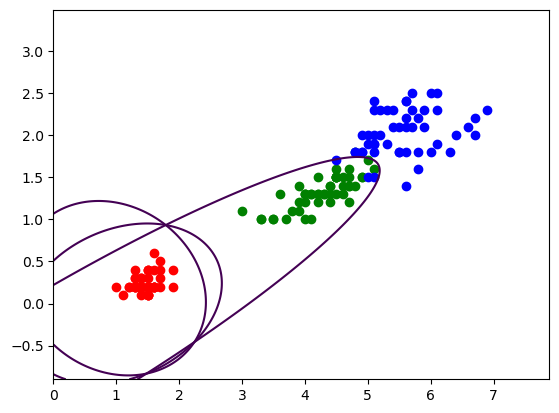

In [23]:
x_max, x_min = train_X.iloc[:, 0].max() + 1, train_X.iloc[:, 0].min() - 1
y_max, y_min = train_X.iloc[:, 1].max() + 1, train_X.iloc[:, 1].min() - 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))

classes = train_y.unique()
train_yy = np.zeros_like(train_y)
for i in range(len(classes)):
    train_yy[train_y == classes[i]] = i

z1 = np.zeros_like(xx)
z2 = np.zeros_like(xx)
z3 = np.zeros_like(xx)
for i in range(xx.shape[0]):
    for j in range(xx.shape[1]):
        z1[i, j] = g4(np.array([xx[i, j], yy[i, j]]))
        z2[i, j] = g5(np.array([xx[i, j], yy[i, j]]))
        z3[i, j] = g6(np.array([xx[i, j], yy[i, j]]))
        
plt.contour(xx, yy, z1, levels = [0])
plt.contour(xx, yy, z2, levels = [0])
plt.contour(xx, yy, z3, levels = [0])
classes = []
data_X = iris_data.iloc[:, 0:2]
data_y = iris_data.iloc[:, -1]
for i in range(len(train_y.unique())):
    classes.append(data_X[data_y == data_y.unique()[i]])
    
plt.scatter(classes[0].iloc[:, 0], classes[0].iloc[:, 1], c='r')
plt.scatter(classes[1].iloc[:, 0], classes[1].iloc[:, 1], c='g')
plt.scatter(classes[2].iloc[:, 0], classes[2].iloc[:, 1], c='b')
plt.show()